In [1]:
import pandas as pd
import random
import copy
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import HuberRegressor
#import data
file_path = 'HousingData.csv'
df = pd.read_csv(file_path).drop(columns = 'B')
print(f'data shape : {df.shape}')
print(f'first five rows: \n {df.head()}')
print(f'null blank check: {df.isnull().sum()}')

data shape : (506, 13)
first five rows: 
       CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

   LSTAT  MEDV  
0   4.98  24.0  
1   9.14  21.6  
2   4.03  34.7  
3   2.94  33.4  
4    NaN  36.2  
null blank check: CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
LSTAT      20
MEDV        0
dtype: int64


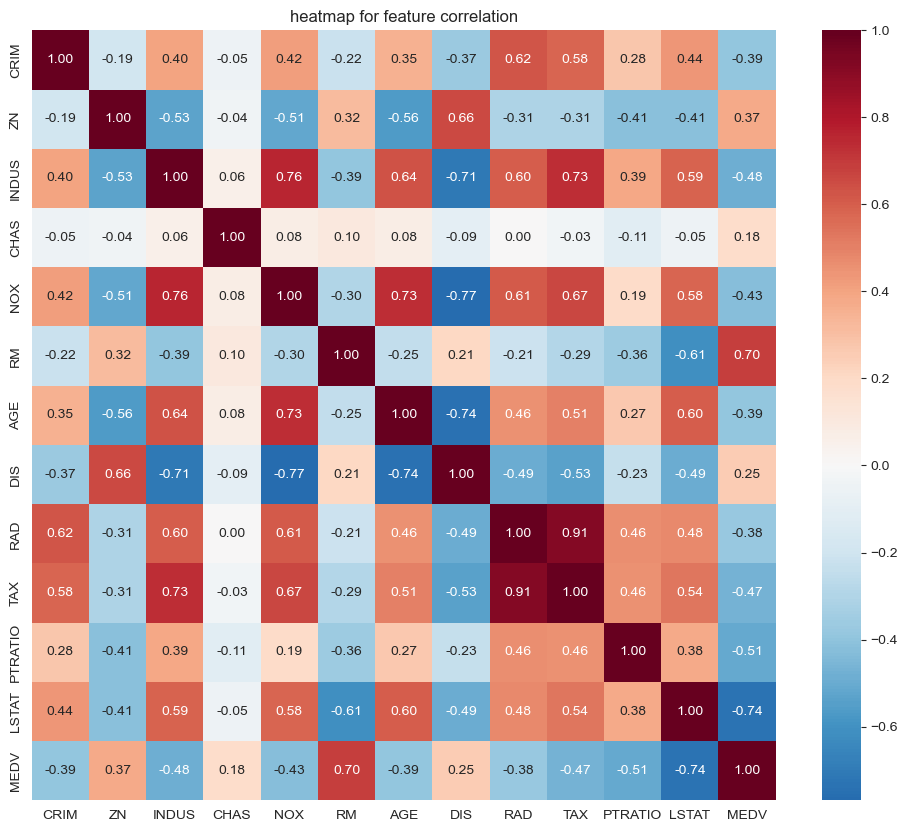

factors with feature > 0.5 with the target column: 
RM         0.695360
PTRATIO   -0.507787
LSTAT     -0.735822
Name: MEDV, dtype: float64


In [2]:
#define target
target_col = 'MEDV'
#Correlation analysis
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('heatmap for feature correlation')
plt.show()

print('factors with feature > 0.5 with the target column: ')
correlations = corr_matrix[target_col].drop(target_col)
high_corr_features = correlations[abs(correlations) > 0.5].sort_values(ascending=False)
print(high_corr_features)

visualizing first three high features: ['RM', 'PTRATIO', 'LSTAT']


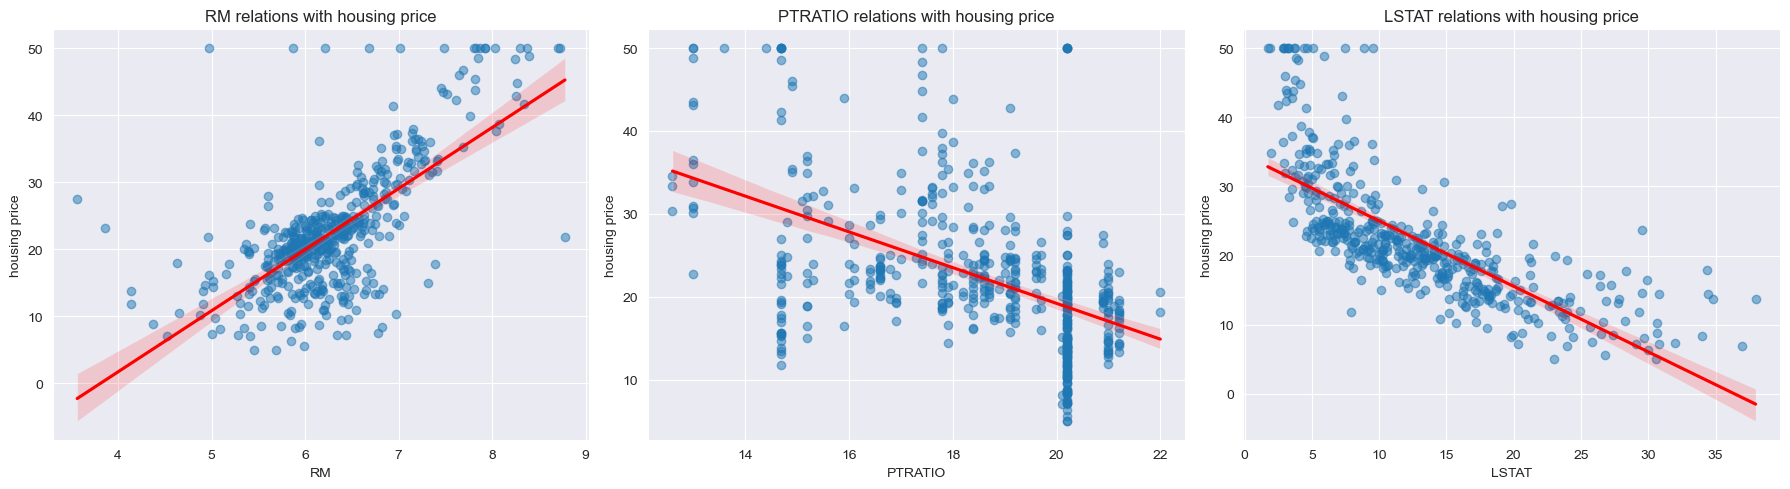

In [3]:
# Visualize the relationships between the top three features most correlated with housing prices
top_features = high_corr_features.index[:3]
print(f"visualizing first three high features: {list(top_features)}")

plt.figure(figsize=(18, 5))

for i, feature in enumerate(top_features):
    plt.subplot(1, 3, i+1)
    sns.regplot(x=df[feature], y=df[target_col], line_kws={"color": "red"}, scatter_kws={'alpha':0.5})
    plt.title(f'{feature} relations with housing price')
    plt.xlabel(feature)
    plt.ylabel('housing price')

plt.tight_layout()
plt.show()

In [4]:
# Data preparation
X = df.drop(target_col, axis=1)
y = df[target_col]

# 20% will be the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 0.80 * 0.125 = 10 %  as validation set (for overfitting check)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val   = imputer.transform(X_val)
X_test  = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

print(f"training set (for modeling): {X_train.shape[0]}")
print(f"testing set (for prediction): {X_test.shape[0]}")

model = LinearRegression()
model.fit(X_train, y_train)

print("\nfinished training。")
# weight for all features
coef_df = pd.DataFrame({'feature': X.columns, 'weight': model.coef_})
coef_df = coef_df.sort_values(by='weight', key=abs, ascending=False)
display(coef_df.head(5))

training set (for modeling): 353
testing set (for prediction): 102

finished training。


,feature,weight
5,RM,3.658322
7,DIS,-3.300936
11,LSTAT,-2.816173
4,NOX,-2.194482
10,PTRATIO,-1.942654


Testing Result:
MSE (MSE): 24.81
determine coefficient (R2 Score): 0.6616 


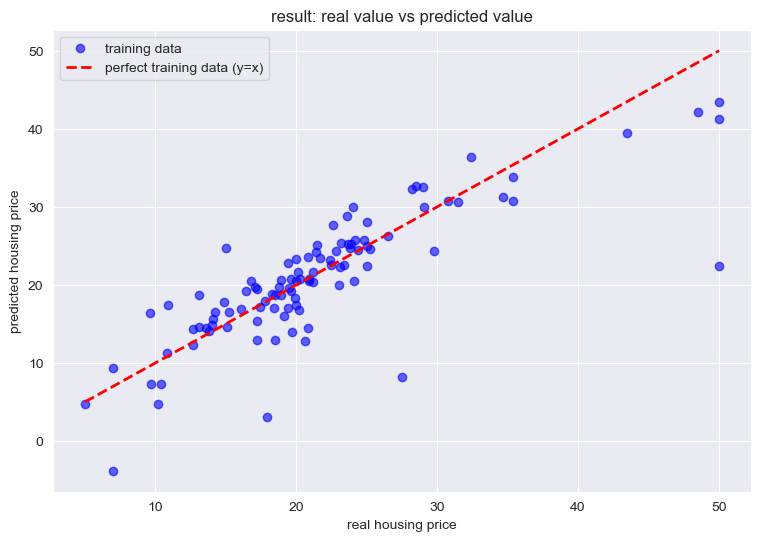

In [5]:
# Linear Regression Analysis
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Testing Result:")
print(f"MSE (MSE): {mse:.2f}")
print(f"determine coefficient (R2 Score): {r2:.4f} ")
# Visualization of results
plt.figure(figsize=(9, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='training data')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='perfect training data (y=x)')

plt.xlabel('real housing price')
plt.ylabel('predicted housing price')
plt.title('result: real value vs predicted value')
plt.legend()
plt.grid(True)
plt.show()

Testing Result:
MSE (MSE): 28.83
determine coefficient (R2 Score): 0.6068 


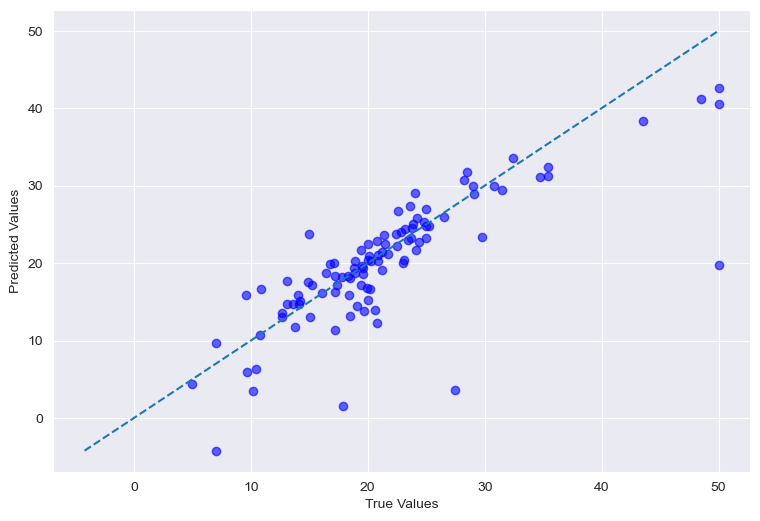

In [6]:
# Robust Regression Analysis(Huber)

#Training
pipe = HuberRegressor(max_iter=1000)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Visualization of results
print("Testing Result:")
print(f"MSE (MSE): {mse:.2f}")
print(f"determine coefficient (R2 Score): {r2:.4f} ")
plt.figure(figsize=(9, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='training data')
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel("True Values")
plt.ylabel("Predicted Values");

In [7]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

print("Data converted to Tensors.")
print(f"Input shape: {X_train_tensor.shape}")

Data converted to Tensors.
Input shape: torch.Size([353, 12])


In [8]:
# Set random seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    # Set random seed for PyTorch (CPU)
    torch.manual_seed(seed_value)
    # Set random seed for PyTorch (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [9]:
# Define the MLP model
class HousingMLP(nn.Module):
    def __init__(self, input_dim):
        super(HousingMLP, self).__init__()
        # Define a multi-layer perceptron with:
        # input layer -> 64 neurons -> 32 neurons -> output layer
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.layers(x)

# initialize the model
input_dim = X_train.shape[1]
mlp_model = HousingMLP(input_dim)

print(mlp_model)

HousingMLP(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


Epoch [100/1000], Train Loss: 11.5459, Val Loss: 24.1713
Epoch [200/1000], Train Loss: 8.2422, Val Loss: 19.1525
Epoch [300/1000], Train Loss: 6.1945, Val Loss: 18.8858
Epoch [400/1000], Train Loss: 5.1135, Val Loss: 19.3701
Epoch [500/1000], Train Loss: 4.5137, Val Loss: 20.8612
Epoch [600/1000], Train Loss: 4.0750, Val Loss: 22.8059
Epoch [700/1000], Train Loss: 3.6984, Val Loss: 23.7627
Epoch [800/1000], Train Loss: 3.3686, Val Loss: 25.5969
Epoch [900/1000], Train Loss: 3.1113, Val Loss: 27.6999
Epoch [1000/1000], Train Loss: 2.8215, Val Loss: 29.5131


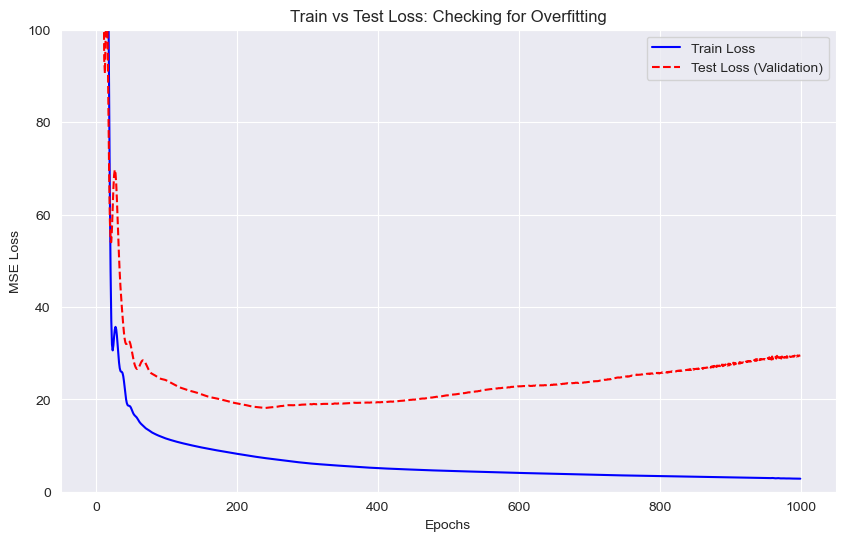

The best result by validating overfitting appears in the round of 241 ，where the Test MSE is: 18.13


In [10]:
input_dim = X_train.shape[1]
mlp_model = HousingMLP(input_dim)
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01) # learning rate 0.01

num_epochs = 1000
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_weights = None
best_epoch_index = 0

# Training and validation loop
for epoch in range(num_epochs):
    mlp_model.train()
    optimizer.zero_grad()
    outputs = mlp_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    mlp_model.eval()
    with torch.no_grad():
        val_output = mlp_model(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)
        val_loss_value = val_loss.item()
        val_losses.append(val_loss_value)

        # Identify the epoch with the lowest validation loss
        if val_loss_value < best_val_loss:
            best_val_loss = val_loss_value
            best_epoch_index = epoch
            best_model_weights = copy.deepcopy(mlp_model.state_dict())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss_value:.4f}',flush=True)

#Loss visualization
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Test Loss (Validation)', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Train vs Test Loss: Checking for Overfitting')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()

min_test_loss = min(val_losses)
best_epoch = val_losses.index(min_test_loss)
print(f"The best result by validating overfitting appears in the round of {best_epoch + 1} ，where the Test MSE is: {min_test_loss:.2f}")

Testing Result:
MSE (MSE): 11.75
R2 Score: 0.8398


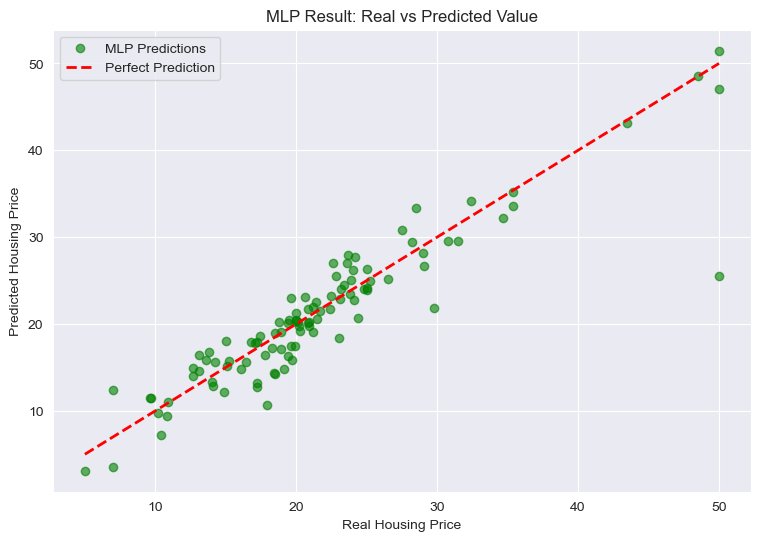

In [11]:
# Evaluate the best MLP model
mlp_model.eval()
mlp_model.load_state_dict(best_model_weights)

with torch.no_grad():
    y_pred_mlp_tensor = mlp_model(X_test_tensor)
    # return numpy for using sklearn to calculate r2 and mse
    y_pred_mlp = y_pred_mlp_tensor.numpy()

#Performance evaluation
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("Testing Result:")
print(f"MSE (MSE): {mse_mlp:.2f}")
print(f"R2 Score: {r2_mlp:.4f}")

# Visualization of results
plt.figure(figsize=(9, 6))
plt.scatter(y_test, y_pred_mlp, color='green', alpha=0.6, label='MLP Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Real Housing Price')
plt.ylabel('Predicted Housing Price')
plt.title('MLP Result: Real vs Predicted Value')
plt.legend()
plt.grid(True)
plt.show()